In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay 

In [2]:
trip_df=pd.read_csv('C:/Users/user/Desktop/　　　/2020-1학기/금_데이터마이닝/SF_bike_data/trip.csv')
station_df=pd.read_csv('C:/Users/user/Desktop/　　　/2020-1학기/금_데이터마이닝/SF_bike_data/station.csv')
weather_df=pd.read_csv('C:/Users/user/Desktop/　　　/2020-1학기/금_데이터마이닝/SF_bike_data/weather.csv')

In [4]:
trip_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [5]:
trip_df.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [7]:
trip_df.duration /= 60
trip_df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

In [9]:
#370분(평균) 이하의 값만 trip time으로 사용한다.
trip_df2=trip_df[trip_df.duration <= 370]

In [12]:
#convert start_date, end_date to datetime
#start_date와 end_date가 같으므로 start_date에 대해서만 year,month,day 정보 추출
trip_df2.start_date=pd.to_datetime(trip_df2.start_date, format='%m/%d/%Y %H:%M')
trip_df2['date'] = trip_df2.start_date.dt.date

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
#해당 날짜에 얼마나 많은 trip이 일어났는지 알아보기
dates={}
for i in trip_df2.date:
    if i not in dates:
        dates[i] = 1
    else:
        dates[i] += 1
        
#dates안에 있는 정보들을 가지고 training을 진행할 것이다.
data = pd.DataFrame.from_dict(dates,'index')
data['date'] = data.index #데이터프레임 data의 해당 인덱스가 날자를 의미하므로, 인덱스를 통해 'date'에 관한 열 생성
data.columns=['trips', 'date']

#train set생성
train=data[:]
train.reset_index(drop=True, inplace=True)

In [14]:
weather_df.date=pd.to_datetime(weather_df.date, format='%m/%d/%Y')
weather_df['date'] = weather_df.date.dt.date

In [15]:
print(train.shape)
print(weather_df.shape)

(733, 2)
(3665, 24)


In [68]:
#weather 안에 있는 zipcode확인
weather_df.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113], dtype=int64)

In [16]:
for zip in weather_df.zip_code.unique():
    print(weather_df[weather_df.zip_code == zip].isnull().sum())
    print()

date                                0
max_temperature_f                   0
mean_temperature_f                  0
min_temperature_f                   0
max_dew_point_f                     0
mean_dew_point_f                    0
min_dew_point_f                     0
max_humidity                        0
mean_humidity                       0
min_humidity                        0
max_sea_level_pressure_inches       0
mean_sea_level_pressure_inches      0
min_sea_level_pressure_inches       0
max_visibility_miles                0
mean_visibility_miles               0
min_visibility_miles                0
max_wind_Speed_mph                  0
mean_wind_speed_mph                 0
max_gust_speed_mph                 13
precipitation_inches                0
cloud_cover                         0
events                            574
wind_dir_degrees                    0
zip_code                            0
dtype: int64

date                                0
max_temperature_f                   

In [17]:
#zip_code에 대해서 확인해봤을 때, zip_code='94107'에서 null 값의 수가 적다는 것을 알 수 있었고,
#zip_code = 94107에 대해서 train을 진행할 것임
weather=weather_df[weather_df.zip_code==94107]

In [18]:
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [20]:
#'rain'과 'Rain'에 대해서 다른 경우로 나눠져 있다는 것을 알 수 있는데
#비가 오는 동일한 날씨이므로 'rain'을 'Rain으로 바꿔주고
#null값에 대해서는 보통인 날씨 'Normal'로 값을 바꿔준다.
weather.loc[weather.events=='rain','events']="Rain"
weather.loc[weather.events.isnull(), 'events']="Normal"

In [21]:
weather.events

0       Normal
1       Normal
2       Normal
3       Normal
4       Normal
         ...  
2200    Normal
2201    Normal
2202      Rain
2203    Normal
2204    Normal
Name: events, Length: 733, dtype: object

In [22]:
events=pd.get_dummies(weather.events) #해당날씨이면 1, 아니면 0

In [23]:
#기존의 weather과 events(pd.get_dummis) 데이터프레임 합침
weather=weather.merge(events, left_index=True, right_index=True)

#사용하지 않는 events, zip_code에 대한 열 제거
weather=weather.drop(['events','zip_code'],1)

from scipy.stats.stats import pearsonr
print (pearsonr(weather.max_wind_Speed_mph[weather.max_gust_speed_mph >= 0], 
               weather.max_gust_speed_mph[weather.max_gust_speed_mph >= 0]))

(0.7888476832259103, 6.027203207272198e-154)


In [24]:
#weather 데이터 프레임을 보면 max_gust에 대해서 null값이 있다는 것을 알 수 있다.
#상관관계 분석(pearsonr)을 통해 wind(바람)과 gust(세찬 바람)은 서로 관련이 있다는 것을 알았으므로, max_gust의 null값에 대해서 max_wind값을 이용하여 채워줄 것이다.
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [25]:
weather.isnull().sum() #null값이 모두 채워진것을 확인

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [26]:
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce') #강수량(precipitation_inch) 데이터 타입을 numeric으로 수정함

#강수량이 True인 것은 비가 왔음을 의미하므로, 강수량 null에 대해서 강수량의 평균값으로 채워준다.
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

train=pd.merge(weather, train, on='date')
train.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,trips
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,28.0,0.0,4.0,286.0,0,0,1,0,0,743
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,35.0,0.0,2.0,291.0,0,0,1,0,0,699
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,31.0,0.0,4.0,284.0,0,0,1,0,0,628
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,29.0,0.0,4.0,284.0,0,0,1,0,0,684
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,30.0,0.0,6.0,277.0,0,0,1,0,0,654


In [27]:
len(station_df.name.unique()) #station_df에 있는 station의 종류가 총70개이고, 중복된 것이 없다는 것을 확인

70

In [28]:
station_df.installation_date=pd.to_datetime(station_df.installation_date, format='%m/%d/%Y')
station_df['installation_date'] = station_df.installation_date.dt.date

In [29]:
#train DataFrame의 date를 통해, 해당 날짜 이전에 설치가 되어있던 docks의 수를 파악함 
total_docks = []
for day in train.date:
    total_docks.append(sum(station_df[station_df.installation_date <= day].dock_count))

train['total_docks'] = total_docks

In [30]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())

#holidays를 제외한 business day찾기
from pandas.tseries.offsets import CustomBusinessDay 
business_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.date_range(start=train.date.min(), end=train.date.max(), freq=business_days)

business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)

In [31]:
#business_day와 holiday의 (True,False)를 (1,0)으로 바꿔준다.
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [32]:
#date의 형식 (year,month,day)를 나눠서 열로 저장한다.
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday

In [33]:
#해당 날에 몇 개의 trip이 발생했는지를 알아내야 하므로 train['trip']을 정답 label로 저장한다.
labels = train.trips
train = train.drop(['trips', 'date'], 1)

In [34]:
#train, test data set 준비
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state = 2)

##trip에 대한 예측이 얼마나 빗나갔는지 아는 것이 목표
def score(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

In [42]:
#모델 설정
model1=RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)

score(model1)

model2=GradientBoostingRegressor(learning_rate = 0.12,
                                 n_estimators = 150,
                                 max_depth = 8,
                                 min_samples_leaf = 1,
                                 random_state = 2)
score(model2)

model3=DecisionTreeRegressor(min_samples_leaf=3,
                             max_depth=8,
                             random_state=2)
score(model3)

model4=AdaBoostRegressor(n_estimators=100,
                         learning_rate = 0.1,
                         loss = 'linear',
                         random_state=2)

score(model4)

56.5160101010099
58.04004205794217
59.599999999999994
96.82539682539687


In [56]:
#score을 비교했을 때, 성능이 좋은 model1,model2에 대해서 학습을 진행할 것이다.
clf1=model1.fit(X_train, y_train)
clf2=model2.fit(X_train,y_train)

clf1_pred=clf1.predict(X_test)
clf2_pred=clf2.predict(X_test)

preds=clf1_pred*0.46 + clf2_pred*0.54 #두 모델을 가장 잘 나타낼 수 있는 임계치 부여(여러번의 수정 끝에 찾았음)

print("Daily error of trip count:", median_absolute_error(y_test, preds))

Daily error of trip count: 50.50574397286823


In [58]:
labels.describe()

count     733.000000
mean      909.982265
std       403.808726
min        81.000000
25%       445.000000
50%      1042.000000
75%      1264.000000
max      1509.000000
Name: trips, dtype: float64

In [59]:
y_test.reset_index(drop=True, inplace=True)

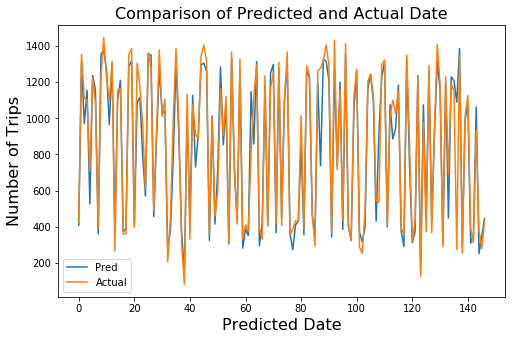

In [60]:
plt.figure(figsize=(8,5))
plt.plot(preds)
plt.plot(y_test)
plt.legend(['Pred','Actual'])
plt.xlabel("Predicted Date", fontsize=16)
plt.ylabel("Number of Trips", fontsize=16)
plt.title("Comparison of Predicted and Actual Date", fontsize=16)
plt.show()

In [61]:
print("Feature rank:")

count=0
for feature in X_train:
    print(count, feature)
    count += 1

Feature rank:
0 max_temperature_f
1 mean_temperature_f
2 min_temperature_f
3 max_dew_point_f
4 mean_dew_point_f
5 min_dew_point_f
6 max_humidity
7 mean_humidity
8 min_humidity
9 max_sea_level_pressure_inches
10 mean_sea_level_pressure_inches
11 min_sea_level_pressure_inches
12 max_visibility_miles
13 mean_visibility_miles
14 min_visibility_miles
15 max_wind_Speed_mph
16 mean_wind_speed_mph
17 max_gust_speed_mph
18 precipitation_inches
19 cloud_cover
20 wind_dir_degrees
21 Fog
22 Fog-Rain
23 Normal
24 Rain
25 Rain-Thunderstorm
26 total_docks
27 business_day
28 holiday
29 year
30 month
31 weekday


In [63]:
m1_feature=[]
m2_feature=[]
feature=np.array(model1.feature_importances_)
feature=np.argsort(-feature)[:10]

print("Feature Importance of model1\n")

for i in range(0,10):
    ind=feature[i]
    print("%d번째로 중요한 feature: " %(i+1))
    print(X_train.columns.values[ind])
    m1_feature.append(X_train.columns.values[ind])
    
print("\n")
feature2=np.array(model2.feature_importances_)
feature2=np.argsort(-feature2)[:10]

print("Feature Importance of model2\n")

for i in range(0,10):
    ind=feature2[i]
    print("%d번째로 중요한 feature: " %(i+1))
    print(X_train.columns.values[ind])
    m2_feature.append(X_train.columns.values[ind])

Feature Importance of model1

1번째로 중요한 feature: 
business_day
2번째로 중요한 feature: 
total_docks
3번째로 중요한 feature: 
month
4번째로 중요한 feature: 
max_temperature_f
5번째로 중요한 feature: 
precipitation_inches
6번째로 중요한 feature: 
weekday
7번째로 중요한 feature: 
wind_dir_degrees
8번째로 중요한 feature: 
year
9번째로 중요한 feature: 
mean_temperature_f
10번째로 중요한 feature: 
max_gust_speed_mph


Feature Importance of model2

1번째로 중요한 feature: 
business_day
2번째로 중요한 feature: 
total_docks
3번째로 중요한 feature: 
month
4번째로 중요한 feature: 
max_temperature_f
5번째로 중요한 feature: 
weekday
6번째로 중요한 feature: 
precipitation_inches
7번째로 중요한 feature: 
wind_dir_degrees
8번째로 중요한 feature: 
min_dew_point_f
9번째로 중요한 feature: 
year
10번째로 중요한 feature: 
mean_wind_speed_mph


In [65]:
m1_feature    

['business_day',
 'total_docks',
 'month',
 'max_temperature_f',
 'precipitation_inches',
 'weekday',
 'wind_dir_degrees',
 'year',
 'mean_temperature_f',
 'max_gust_speed_mph']

In [66]:
m2_feature

['business_day',
 'total_docks',
 'month',
 'max_temperature_f',
 'weekday',
 'precipitation_inches',
 'wind_dir_degrees',
 'min_dew_point_f',
 'year',
 'mean_wind_speed_mph']